<a href="https://colab.research.google.com/github/salehafzoon/PA_on_Bone/blob/main/Paper_PA_on_Bone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Role of Physical Activity on Bone Mineral Density 

## Import Packages

In [ ]:
!pip install shap
!pip install pingouin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from statsmodels.stats.stattools import durbin_watson
import statsmodels.stats.api as sms 
from statsmodels.compat import lzip
import shap
import pingouin as pg
import scipy.stats as ss
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 14.6 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.2-py3-none-any.whl size=196206 sha256=86b8c2afd942989e543c25f4904a7c582984363653d8a174b63958696b71b054
  Stored in directory: /root/.cache/pip/wheels/11/5a/63/a6d32fc26fa462c731f65480bfb98ff7bd39b8ebcb4bc6c2fe
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=ba2f88e622382138fa1cb08ce8ecf334678297a2def542c553d148fc9c3f8e56
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils
  Attempting uninstall: statsmodels
    Found existing install

In [ ]:
%matplotlib notebook 

## Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_excel(r"/content/drive/MyDrive/Colab Notebooks/DATABASE v5.xlsx",sheet_name='DATABASE')

print(data.shape)
data.columns

(10175, 18)


Index(['Bone_Density', 'Gender', 'Age', 'Ethnic', 'SistolicBP', 'DiastolicBP',
       'Mass', 'Height', 'GripStrength', 'CholesterolHDL', 'CholesterolTOT',
       'Estrogene', 'SexHormoneBindingGlobuline', 'Calcium_urine',
       'VitamineD_Blood', 'Vigorous_Int_min', 'Sum_Control_hours',
       'Total_Acc'],
      dtype='object')

First approach

In [ ]:
col =  ['Bone_Density', 'Gender', 'Age', 'Ethnic',
       'Mass', 'GripStrength', 'Vigorous_Int_min', 'Sum_Control_hours', 'Total_Acc']

In [ ]:
data = data[col]
print(data.shape)
data = data[data['Gender'] == 2]
print(data.shape)
data = data[data['Age'] < 80]
print(data.shape)
data = data[data['Sum_Control_hours'] > 8]
print(data.shape)
data = data[data['Ethnic'] != 7]
data = data[data['Ethnic'] != 2]
print(data.shape)
data = data.replace([np.inf, - np.inf], np.nan)
data = data.dropna()
print(data.shape)
data = data[data['GripStrength'] > 0]
print(data.shape)

(10175, 9)
(5172, 9)
(4981, 9)
(1358, 9)
(1198, 9)
(1132, 9)
(1066, 9)


Second Approach

In [ ]:
col =  ['Bone_Density', 'Gender', 'Age', 'Ethnic',
       'Mass', 'GripStrength', 'Vigorous_Int_min', 'Sum_Control_hours', 'Total_Acc']

In [ ]:
data = data[col]
print(data.shape)
data = data[data['Gender'] == 2]
print(data.shape)
data = data[data['Age'] < 80]
print(data.shape)
data = data[data['Sum_Control_hours'] > 8]
print(data.shape)
data = data[data['Ethnic'] != 7]
data = data[data['Ethnic'] != 2]
print(data.shape)
data = data.replace([np.inf, - np.inf], np.nan)
data = data.dropna()
print(data.shape)
data = data[data['GripStrength'] > 0]
print(data.shape)

(1066, 9)
(1066, 9)
(1066, 9)
(1066, 9)
(1066, 9)
(1066, 9)
(1066, 9)


In [ ]:
type(data)

pandas.core.frame.DataFrame

## Analysis of Bone Mineral Density Differences among Ethnicity

In [ ]:
# pg.normality(data=data, dv='Bone_Density', group='Ethnic', method='normaltest')

In [ ]:
pg.kruskal(data=data, dv='Bone_Density', between='Ethnic')

Source  ddof1           H         p-unc
Kruskal  Ethnic      3  109.050013  1.757004e-23

In [ ]:
pg.pairwise_ttests(data=data, dv='Bone_Density', between='Ethnic', parametric=False)

pairwise_ttests is deprecated, use pairwise_tests instead.


Contrast  A  B  Paired  Parametric    U-val alternative         p-unc  \
0   Ethnic  1  3   False       False  41876.0   two-sided  4.880175e-01   
1   Ethnic  1  4   False       False  11108.0   two-sided  4.571441e-10   
2   Ethnic  1  6   False       False  11758.5   two-sided  1.929623e-02   
3   Ethnic  3  4   False       False  37258.0   two-sided  2.833778e-21   
4   Ethnic  3  6   False       False  41348.5   two-sided  2.784034e-02   
5   Ethnic  4  6   False       False  24644.0   two-sided  9.160990e-17   

     hedges  
0  0.079613  
1 -0.666901  
2  0.285559  
3 -0.795130  
4  0.214097  
5  0.941291

In [ ]:
data.describe()

Bone_Density  Gender          Age       Ethnic         Mass  \
count   1066.000000  1066.0  1066.000000  1066.000000  1066.000000   
mean       0.756785     2.0    56.730769     3.327392    76.348499   
std        0.142540     0.0    10.866658     1.351313    19.389966   
min        0.413000     2.0    40.000000     1.000000    39.800000   
25%        0.653250     2.0    47.000000     3.000000    62.700000   
50%        0.742000     2.0    56.000000     3.000000    73.050000   
75%        0.852000     2.0    66.000000     4.000000    87.050000   
max        1.277000     2.0    79.000000     6.000000   173.600000   

       GripStrength  Vigorous_Int_min  Sum_Control_hours     Total_Acc  
count   1066.000000       1066.000000        1066.000000   1066.000000  
mean      54.889024         93.457903          14.289236  12994.204113  
std       11.362627         65.632920           1.671650   3463.938883  
min       14.800000          0.281602           8.066486   3552.800022  
25%       47.600000         45.649710          13.474321  10646.934908  
50%       54.950000         80.061305          14.581934  12804.726578  
75%       62.300000        125.982808          15.401090  15235.098748  
max       93.200000        442.476704          18.149280  30737.758199

In [ ]:
means = data.groupby('Ethnic').mean()

In [ ]:
stds = data.groupby('Ethnic').std()

In [ ]:
data_Ethnic = data.groupby(['Ethnic'])['Bone_Density'].mean()
yerr = np.array(stds['Bone_Density'])
data_Ethnic.plot(kind='bar', yerr=yerr, fontsize=14, color='#00688B', error_kw=dict(lw=3, capsize=4, capthick=2), width= 0.8)
plt.ylabel('Bone Mineral Density (gm/cm2)', fontsize=16)
plt.xlabel('Ethnicity', fontsize=16)
plt.xticks([0, 1, 2, 3, 4], ['MA', 'OH', 'NHW', 'NHB', 'NHA'], rotation=0, fontsize=14)
plt.ylim([0, 1.1])

<IPython.core.display.Javascript object>

(0.0, 1.1)

In [ ]:
Ethnicy = 1
if Ethnicy != 0:
    data = data[data['Ethnic'] == Ethnicy]

In [ ]:
means

Bone_Density  Gender        Age       Mass  GripStrength  \
Ethnic                                                             
1           0.744933     2.0  54.818792  75.911409     51.028188   
3           0.734605     2.0  57.926199  76.580996     54.354244   
4           0.842653     2.0  56.087866  84.632636     60.283682   
6           0.707265     2.0  55.191176  61.342647     51.769853   

        Vigorous_Int_min  Sum_Control_hours     Total_Acc  
Ethnic                                                     
1             119.585491          14.727134  14484.255412  
3              91.611411          14.104886  12656.320147  
4              76.212703          14.461877  12582.205260  
6             102.497540          14.240780  13432.315814

In [ ]:
stds

Bone_Density  Gender        Age       Mass  GripStrength  \
Ethnic                                                             
1           0.135917     0.0  10.284503  17.377749     11.040234   
3           0.127795     0.0  11.195048  18.419179     10.436239   
4           0.152312     0.0  10.365820  20.987612     12.479958   
6           0.126612     0.0  10.537070  12.248741      9.743414   

        Vigorous_Int_min  Sum_Control_hours    Total_Acc  
Ethnic                                                    
1              77.628546           1.348710  3668.740474  
3              64.008251           1.638991  3386.807714  
4              56.548405           1.885723  3265.277008  
6              62.803857           1.616581  3425.736543

## Linear Relationship for Physical Activity and Sedentarism

In [ ]:
vect = ['Age', 'Mass', 'GripStrength', 'Vigorous_Int_min', 'Total_Acc']

rs = np.zeros(len(vect), object)
ps = np.zeros(len(vect), object)

for ii in range(0, len(vect)):
    rs[ii] = ss.pearsonr(x=data[vect[ii]], y=data['Bone_Density'])[0]
    ps[ii] = ss.pearsonr(x=data[vect[ii]], y=data['Bone_Density'])[1]

In [ ]:
# r = {'Age': [rs[0], ps[0]], 'Mass': [rs[1], ps[1]], 'Height': [rs[2], ps[2]], 'GripStrength': [rs[3], ps[3]], 
#      'Estrogen': [rs[4], ps[4]], 'Vigorous_Int_min': [rs[5], ps[5]], 
#                                                       'Total_Acc': [rs[6], ps[6]], 'BMI': [rs[7], ps[7]]}

# r = pd.DataFrame(r, index=['r', 'p'])
# r
r = {'Age': [rs[0], ps[0]], 'Mass': [rs[1], ps[1]], 'GripStrength': [rs[2], ps[2]],
     'Vigorous_Int_min': [rs[3], ps[3]], 'Total_Acc': [rs[4], ps[4]]}
r = pd.DataFrame(r, index=['r', 'p'])
r

Age          Mass  GripStrength  Vigorous_Int_min  Total_Acc
r -6.338787e-01  3.990848e-01      0.300874          0.278586   0.195789
p  4.068085e-18  4.619058e-07      0.000193          0.000581   0.016712

In [ ]:
#sns.pairplot(data[['Bone_Density', 'Age', 'Mass', 'Ethnic', 'Total_Acc', 'Vigorous_Int_min']], hue="Ethnic")

Due to the linear analysis, only the independent variables Age, Mass, Total_Acc, and Vigourous Intensity will be used.

## Split data

In [ ]:
act_var = 1

if act_var == 0:

    X = data[['Age', 'Mass', 'GripStrength', 'Total_Acc']]
    y = data[['Bone_Density']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    
elif act_var == 1:

    X = data[['Age', 'Mass', 'GripStrength', 'Vigorous_Int_min']]
    y = data[['Bone_Density']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## Scaling Up Features

In [ ]:
scaler = preprocessing.StandardScaler()
sX_train = scaler.fit_transform(X_train)
sX_test = scaler.transform(X_test)

## Model

In [ ]:
linear_model = LinearRegression()
linear_model.fit(sX_train, y_train)

LinearRegression()

In [ ]:
coefs = pd.DataFrame(index=X.columns)
coefs["coef"] = [linear_model.coef_[:,ii] for ii in range(0, linear_model.coef_.shape[1])]
coefs.loc['Intercept'] = linear_model.intercept_
coefs

coef
Age                 [-0.08362351964412501]
Mass                 [0.03090639438594888]
GripStrength       [-0.004971820932019002]
Vigorous_Int_min  [-0.0045832265284981195]
Intercept                         0.741235

## Cross-Validation

In [ ]:
scores = cross_val_score(linear_model, sX_train, y_train, scoring='r2', cv=4)
scores

array([0.50077974, 0.41525887, 0.47654814, 0.44719954])

## Predict

In [ ]:
linear_predictions_train = linear_model.predict(sX_train)
linear_predictions_test = linear_model.predict(sX_test)

## Model Evaluation

### Variance Explained

In [ ]:
r2_train = np.round(linear_model.score(sX_train, y_train), 3)
print('R^2_train: {0}'.format(r2_train))
r2_test = np.round(linear_model.score(sX_test, y_test), 3)
print('R^2_test: {0}'.format(r2_test))

R^2_train: 0.499
R^2_test: 0.382


### Mean Squared Error

In [ ]:
mse_train = np.round(mean_squared_error(y_train, linear_predictions_train), 3)
print('MSE_train: {0}'.format(mse_train))
mse_test = np.round(mean_squared_error(y_test, linear_predictions_test), 3)
print('MSE_test: {0}'.format(mse_test))

MSE_train: 0.008
MSE_test: 0.016


### Residuals Analysis

In [ ]:
residuals_train = {'Actual_train': np.array(y_train).flatten(), 'Predicted_train': linear_predictions_train.flatten()}
residuals_train = pd.DataFrame(residuals_train)
residuals_train['Residuals'] = abs(residuals_train['Actual_train']) - abs(residuals_train['Predicted_train'])

residuals_test = {'Actual_test': np.array(y_test).flatten(), 'Predicted_test': linear_predictions_test.flatten()}
residuals_test = pd.DataFrame(residuals_test)
residuals_test['Residuals'] = abs(residuals_test['Actual_test']) - abs(residuals_test['Predicted_test'])

#### Autocorrelation of residuals

In [ ]:
print(durbin_watson(residuals_train['Residuals'])) 
print(durbin_watson(residuals_test['Residuals'])) 

1.6991667475938943
2.736422108455714


#### Normal Distribution of residuals

In [ ]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
t_train = sms.jarque_bera(residuals_train['Residuals'])
print(lzip(name, t_train))

t_test = sms.jarque_bera(residuals_test['Residuals'])
print(lzip(name, t_test))

[('Jarque-Bera', 0.5994571542041108), ('Chi^2 two-tail prob.', 0.741019323000678), ('Skew', 0.10954793282209171), ('Kurtosis', 2.730007549153838)]
[('Jarque-Bera', 8.641546828529563), ('Chi^2 two-tail prob.', 0.013289601199559993), ('Skew', -0.32687679802802727), ('Kurtosis', 5.546731964394256)]


#### Homoscedasticity

In [ ]:
residuals_train.plot.scatter(x='Predicted_train', y='Residuals', color='black')
plt.hlines(0, 0.5, 1.1, 'r')
print('Mean residuals = ', np.mean(residuals_train['Residuals']))

<IPython.core.display.Javascript object>

Mean residuals =  3.6851940733356035e-17


In [ ]:
residuals_test.plot.scatter(x='Predicted_test', y='Residuals', color='black')
plt.hlines(0, 0.5, 1.1, 'r')
print('Mean residuals = ', np.mean(residuals_test['Residuals']))

<IPython.core.display.Javascript object>

Mean residuals =  -0.02788925328380669


In [ ]:
# heteroscedasticity
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(np.array(residuals_train['Residuals']), sX_train)
lzip(name, test)

[('F statistic', 0.7320128167620231), ('p-value', 0.8755609641491473)]

In [ ]:
# heteroscedasticity
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(np.array(residuals_test['Residuals']), sX_test)
lzip(name, test)

[('F statistic', 0.9257643438607662), ('p-value', 0.5497498004175321)]

#### Multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame(index=X.columns)
vif["VIF Factor"] = [variance_inflation_factor(sX_train, ii) for ii in range(sX_train.shape[1])]
vif

VIF Factor
Age                 1.552905
Mass                1.107554
GripStrength        1.299842
Vigorous_Int_min    1.282294

## Overall Analysis and other Machine Learning Options

### Overall linear regression

In [ ]:
residuals_train.plot.scatter(x='Predicted_train', y='Actual_train', color='black')
p1 = max(max(residuals_train['Predicted_train']), max(residuals_train['Actual_train']))
p2 = min(min(residuals_train['Predicted_train']), min(residuals_train['Actual_train']))
plt.plot([p1, p2], [p1, p2], 'r--', linewidth=3)
plt.text(min(residuals_train['Predicted_train']), max(residuals_train['Actual_train'])-0.1, 
         '$R^2$ =' + str(r2_train), fontsize=12, fontweight='bold')
m, b = np.polyfit(residuals_train['Predicted_train'], residuals_train['Actual_train'], 1)
plt.plot(residuals_train['Predicted_train'], m*residuals_train['Predicted_train']+b, 'b', linewidth=3)

<IPython.core.display.Javascript object>

In [ ]:
residuals_test.plot.scatter(x='Predicted_test', y='Actual_test', color='black', s=30)
p1 = max(max(residuals_test['Predicted_test']), max(residuals_test['Actual_test']))
p2 = min(min(residuals_test['Predicted_test']), min(residuals_test['Actual_test']))
plt.plot([p1, p2], [p1, p2], 'r--', linewidth=3)
plt.text(min(residuals_test['Predicted_test']), max(residuals_test['Actual_test'])-0.1, 
         '$R^2$ =' + str(r2_test), fontsize=12, fontweight='bold')
m, b = np.polyfit(residuals_test['Predicted_test'], residuals_test['Actual_test'], 1)
plt.plot(residuals_test['Predicted_test'], m*residuals_test['Predicted_test']+b, 'b', linewidth=3)
plt.ylabel('Observed Values', fontsize=14)
plt.xlabel('Predicted Values', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

<IPython.core.display.Javascript object>

(array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3]),
 <a list of 11 Text major ticklabel objects>)

### SHAP Values

In [1]:
!pip install shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

from google.colab import drive
drive.mount('/content/drive')

%matplotlib notebook 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.6 MB/s 
Mounted at /content/drive


In [2]:
df = pd.read_excel(r"/content/drive/MyDrive/Colab Notebooks/DATABASE v5.xlsx",sheet_name='DATABASE')

print(df.columns)
df.head(4)

Index(['Bone_Density', 'Gender', 'Age', 'Ethnic', 'SistolicBP', 'DiastolicBP',
       'Mass', 'Height', 'GripStrength', 'CholesterolHDL', 'CholesterolTOT',
       'Estrogene', 'SexHormoneBindingGlobuline', 'Calcium_urine',
       'VitamineD_Blood', 'Vigorous_Int_min', 'Sum_Control_hours',
       'Total_Acc'],
      dtype='object')


Bone_Density  Gender  Age  Ethnic  SistolicBP  DiastolicBP  Mass  Height  \
0           NaN       1   69       4  112.666667    74.000000  78.3   171.3   
1         0.815       1   54       3  157.333333    61.333333  89.5   176.8   
2           NaN       1   72       3  142.000000    82.000000  88.9   175.3   
3           NaN       1    9       3  104.666667    36.666667  32.2   137.3   

   GripStrength  CholesterolHDL  CholesterolTOT  Estrogene  \
0          55.2            65.0           167.0     14.800   
1          61.5            50.0           170.0     14.000   
2          91.0            60.0           126.0     26.500   
3          32.2            61.0           168.0      2.117   

   SexHormoneBindingGlobuline  Calcium_urine  VitamineD_Blood  \
0                       62.45            9.5             28.9   
1                       29.16            9.2             61.9   
2                       54.60            8.9            126.0   
3                      114.20            NaN             73.3   

   Vigorous_Int_min  Sum_Control_hours  Total_Acc  
0               NaN                0.0        NaN  
1               NaN                0.0        NaN  
2               NaN                0.0        NaN  
3               NaN                0.0        NaN

In [3]:
# fig = plt.figure(figsize = (15,20))
# ax = fig.gca()
# df.hist(ax = ax)

# plt.savefig("/content/drive/MyDrive/PA on Bone/Plots/" +"raw_data_histogram.pdf",dpi=200,
#               bbox_inches='tight')

In [4]:
feats = ['Age', 'Mass', 'GripStrength','Total_Acc','Ethnic','Gender','Sum_Control_hours',
         'Vigorous_Int_min']
target = 'Bone_Density'

data = df[feats +[target]]

data = data[data['Gender'] == 2]
data = data[data['Age'] < 80]
data = data[data['Sum_Control_hours'] > 8]
data = data[data['Ethnic'] != 7]
data = data[data['Ethnic'] != 6]
data = data.replace([np.inf, - np.inf], np.nan)
data = data.dropna()
data = data[data['GripStrength'] > 0]
print(data.shape)

data.head(10)

(1044, 9)


Age   Mass  GripStrength     Total_Acc  Ethnic  Gender  Sum_Control_hours  \
4    73   52.0          30.9   7292.593313       3       2          12.733521   
7    61   93.4          45.9  10725.330844       3       2          13.105849   
9    56   61.8          38.8  18438.607753       3       2          14.420565   
47   69   59.5          46.3   9980.986864       3       2          13.284891   
56   60  104.9          68.9  13342.070505       4       2          16.248806   
58   65   55.4          32.3  11650.574519       2       2          16.590217   
59   62   71.8          51.8  16392.099931       3       2          15.629849   
61   54   79.4          45.1  14702.996268       3       2          15.403510   
69   72   72.4          58.4  11622.069054       4       2          11.116319   
76   43   76.8          51.3  15653.538769       3       2          14.563592   

    Vigorous_Int_min  Bone_Density  
4          18.089855         0.722  
7          52.971143         0.806  
9         233.818569         0.657  
47         62.634431         0.595  
56         44.515997         0.758  
58         20.856881         0.807  
59        160.024691         0.700  
61        123.845380         0.705  
69         40.482399         1.073  
76        160.273942         0.815

Correlation before NaN removal

In [5]:
print("\ndata shape before NaN removal:",data.shape,"\n")
print(data.isna().sum())
for f in feats:
  corr = data[target].corr(data[f])
  print ("Correlation between ", target, ",", f, ":", round(corr, 2))

data.dropna(axis='rows',inplace=True)
print("\ndata shape after NaN removal:",data.shape,"\n")
print(data.isna().sum())

for f in feats:
  corr = data[target].corr(data[f])
  print ("Correlation between ", target, ",", f, ":", round(corr, 2))

data.head(4)


data shape before NaN removal: (1044, 9) 

Age                  0
Mass                 0
GripStrength         0
Total_Acc            0
Ethnic               0
Gender               0
Sum_Control_hours    0
Vigorous_Int_min     0
Bone_Density         0
dtype: int64
Correlation between  Bone_Density , Age : -0.44
Correlation between  Bone_Density , Mass : 0.49
Correlation between  Bone_Density , GripStrength : 0.4
Correlation between  Bone_Density , Total_Acc : 0.08
Correlation between  Bone_Density , Ethnic : 0.18
Correlation between  Bone_Density , Gender : nan
Correlation between  Bone_Density , Sum_Control_hours : 0.04
Correlation between  Bone_Density , Vigorous_Int_min : 0.09

data shape after NaN removal: (1044, 9) 

Age                  0
Mass                 0
GripStrength         0
Total_Acc            0
Ethnic               0
Gender               0
Sum_Control_hours    0
Vigorous_Int_min     0
Bone_Density         0
dtype: int64
Correlation between  Bone_Density , Age : -0.44
C

Age  Mass  GripStrength     Total_Acc  Ethnic  Gender  Sum_Control_hours  \
4    73  52.0          30.9   7292.593313       3       2          12.733521   
7    61  93.4          45.9  10725.330844       3       2          13.105849   
9    56  61.8          38.8  18438.607753       3       2          14.420565   
47   69  59.5          46.3   9980.986864       3       2          13.284891   

    Vigorous_Int_min  Bone_Density  
4          18.089855         0.722  
7          52.971143         0.806  
9         233.818569         0.657  
47         62.634431         0.595

In [6]:
#0- all,1- , 2- , 3-white, 4- black, 6- Asian
ethnic_names = ['All', 'Mexican American', 'Other Hispanic', 'Non-Hispanic White',
                'Non-Hispanic Black', 'Non-Hispanic Asian'
                , 'Other Race'
                ]
ethnics_id = [0]
ethnics_id.extend(list(data['Ethnic'].unique()))
ethnics_id.sort()
print("ethnics_id:",ethnics_id)

data.groupby(["Ethnic"], as_index=False).count()

ethnics_id: [0, 1, 2, 3, 4]


Ethnic  Age  Mass  GripStrength  Total_Acc  Gender  Sum_Control_hours  \
0       1  149   149           149        149     149                149   
1       2  114   114           114        114     114                114   
2       3  542   542           542        542     542                542   
3       4  239   239           239        239     239                239   

   Vigorous_Int_min  Bone_Density  
0               149           149  
1               114           114  
2               542           542  
3               239           239

In [7]:
# i = 0 -> all data(all races)
ethnics_data = [data]

# i = 1 -> ....
for eth_id in ethnics_id[1:]:
  ethnics_data.append(data[(data.Ethnic == eth_id)])

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

Performance comparisons

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

pipelines = []
pipelines.append(('Linear', Pipeline([('Linear', LinearRegression())])))
# pipelines.append(('Logistic', Pipeline([('Logistic', LogisticRegression())])))
pipelines.append(('Ridge', Pipeline([('Ridge', Ridge())])))
# pipelines.append(('Decision Tree', Pipeline([('Decision Tree', DecisionTreeRegressor())])))
pipelines.append(('Random Forest', Pipeline([('Rnd Forest', RandomForestRegressor())])))
pipelines.append(('XGBRegressor', Pipeline([('XGB', XGBRegressor(silent = True))])))


In [10]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tabulate import tabulate


feature_names = ['Age', 'Mass', 'GripStrength']
target = 'Bone_Density'

act_var = 1
if act_var == 0:
  feature_names.append('Total_Acc');
elif act_var == 1:
  feature_names.append('Vigorous_Int_min');

for eth_data,eth_name in zip(ethnics_data, ethnic_names):
  
  # data preparation
  X = eth_data[feature_names]
  y = eth_data[target]  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  

  # preprocessing
  scaler = preprocessing.StandardScaler()
  sX_train = scaler.fit_transform(X_train)
  sX_test = scaler.transform(X_test)

  res = []

  for name, model in pipelines:

    #model fitting
    model.fit(sX_train, y_train)
    y_pred = model.predict(sX_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    res.append([name, round(r2,4), round(mae,4), round(mse,4)])

  print(eth_name, "Gender Results", eth_data[feature_names].shape,":\n")
  print(tabulate(res, headers=['Model','R2','MAE','MSE']))
  print("\n###########################################")
  


All Gender Results (1044, 4) :

Model              R2     MAE     MSE
-------------  ------  ------  ------
Linear         0.3986  0.0874  0.0125
Ridge          0.3986  0.0875  0.0125
Random Forest  0.3258  0.092   0.014
XGBRegressor   0.3946  0.087   0.0126

###########################################
Mexican American Gender Results (149, 4) :

Model              R2     MAE     MSE
-------------  ------  ------  ------
Linear         0.2386  0.0856  0.0145
Ridge          0.2432  0.0856  0.0144
Random Forest  0.2587  0.0957  0.0142
XGBRegressor   0.1909  0.0971  0.0154

###########################################
Other Hispanic Gender Results (114, 4) :

Model              R2     MAE     MSE
-------------  ------  ------  ------
Linear         0.5092  0.0679  0.0065
Ridge          0.5156  0.0675  0.0064
Random Forest  0.329   0.0797  0.0088
XGBRegressor   0.1506  0.0788  0.0112

###########################################
Non-Hispanic White Gender Results (542, 4) :

Model             

In [11]:
model = LinearRegression()
# model = Ridge()

# model = DecisionTreeRegressor()
# model = RandomForestRegressor()
# model = GradientBoostingRegressor(random_state=0)
# model = XGBRegressor(objective="reg:tweedie", n_estimators = 10, seed = 123)
model_name = type(model).__name__
model_name

'LinearRegression'

In [12]:
import os

shap_plots_dir = '/content/drive/MyDrive/PA on Bone/Plots/SHAP/'
shap_plots_dir += model_name + '/'

for p in ['Summary plots', 'Decision plots', 'Bar plots']:
  path = shap_plots_dir + p +  "/"
  # Check whether the specified path exists or not
  isExist = os.path.exists(path)

  if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(path)
    print(path, "\t\tis created!")
  else:
    print(path, "\t\texistes")

/content/drive/MyDrive/PA on Bone/Plots/SHAP/LinearRegression/Summary plots/ 		existes
/content/drive/MyDrive/PA on Bone/Plots/SHAP/LinearRegression/Decision plots/ 		existes
/content/drive/MyDrive/PA on Bone/Plots/SHAP/LinearRegression/Bar plots/ 		existes


(1044, 4)


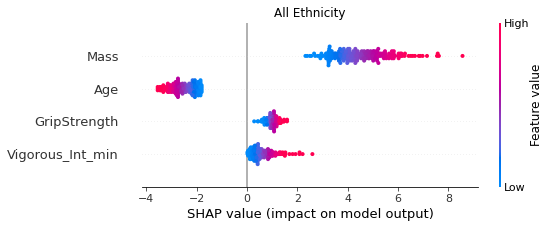

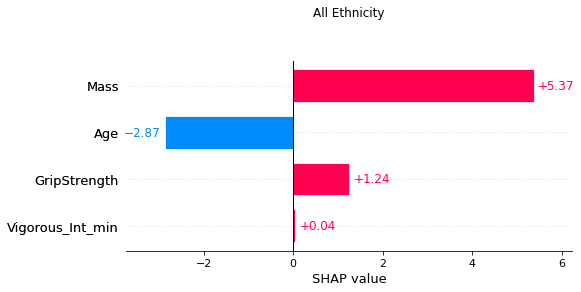

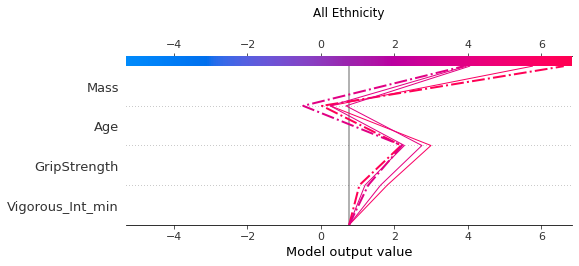

(149, 4)


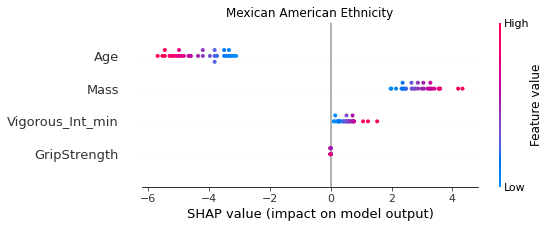

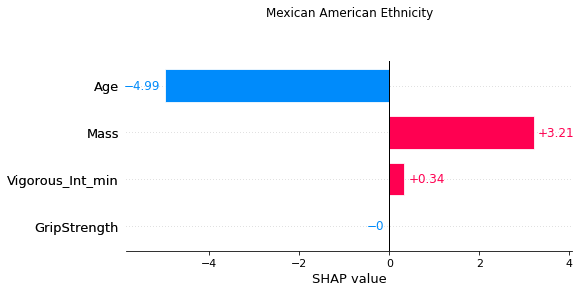

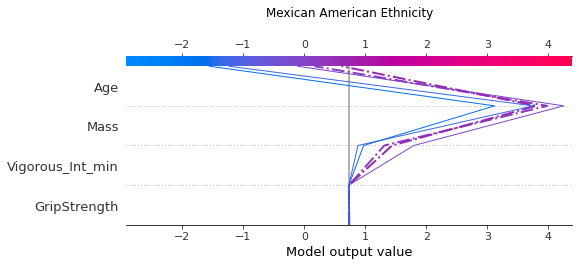

(114, 4)


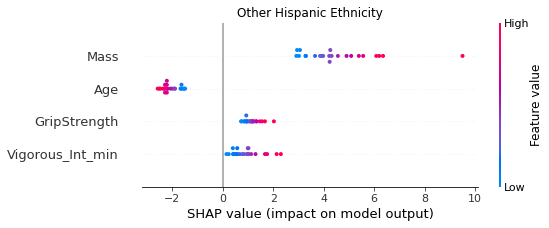

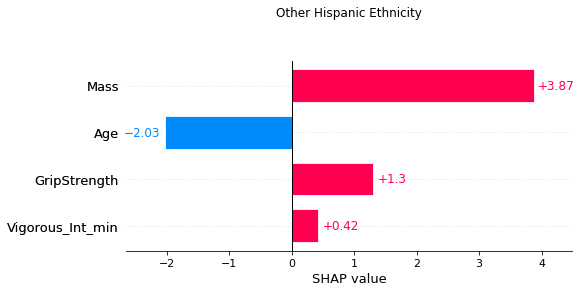

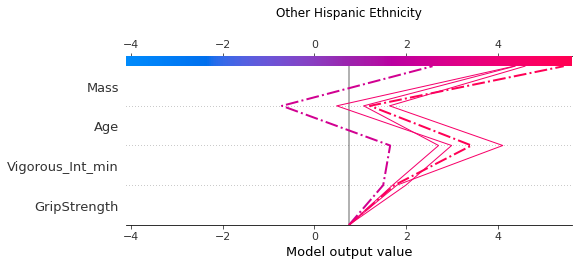

(542, 4)


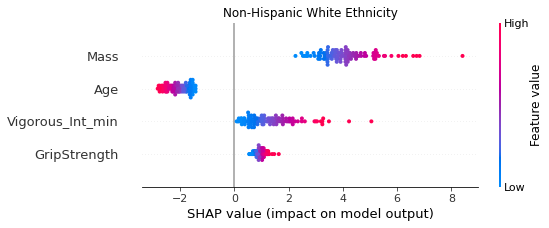

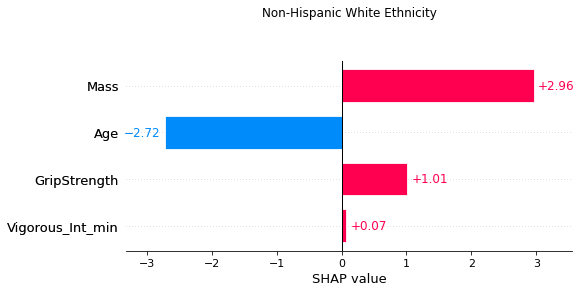

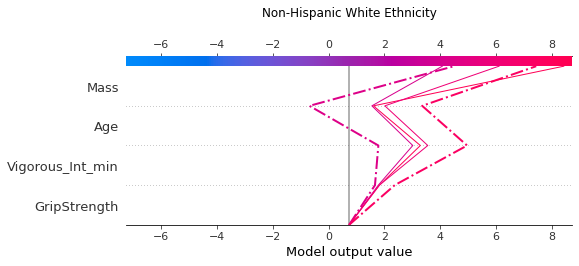

(239, 4)


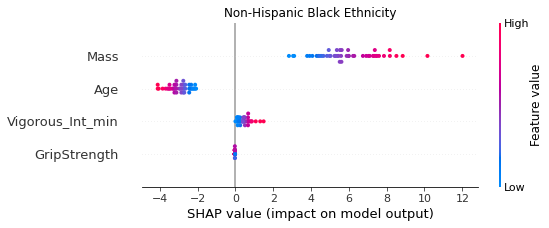

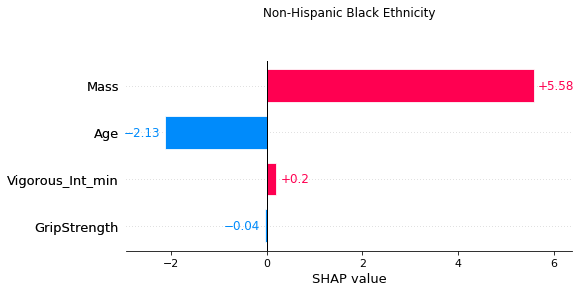

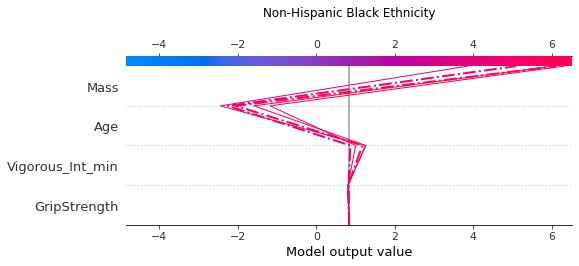

In [33]:
%matplotlib inline

feature_names = ['Age', 'Mass', 'GripStrength']
target = 'Bone_Density'

act_var = 1
if act_var == 0:
  feature_names.append('Total_Acc');
elif act_var == 1:
  feature_names.append('Vigorous_Int_min');

for eth_data,eth_name in zip(ethnics_data, ethnic_names):
  
  print(eth_data[feature_names].shape)
  # data preparation
  X = eth_data[feature_names]
  y = eth_data[target]  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)  

  # preprocessing
  scaler = preprocessing.StandardScaler()
  sX_train = scaler.fit_transform(X_train)
  sX_test = scaler.transform(X_test)

  #model fitting
  model.fit(sX_train, y_train)

  shap.initjs()
  explainer = shap.LinearExplainer(model, sX_train)                             #### for linear models
  #  explainer = shap.TreeExplainer(model, sX_train)                            #### for non-linear models 

  shap_values = explainer.shap_values(X_test)                                   #### for linear models
  # shap_values = explainer.shap_values(X_test, check_additivity=False)         #### for non-linear models
  

  # summary plot
  shap.initjs()
  shap.summary_plot(shap_values, X_test, show=False)
  plt.title(eth_name +" Ethnicity", y=1.2)

  plt.savefig(shap_plots_dir + "Summary plots/" + eth_name + "_act" + str(act_var) +"_summary_plot.pdf",dpi=200,
              bbox_inches='tight')
  plt.show()

  # bar plot
  shap.initjs()
  shap_values = explainer(X_train)                                              #### for linear models
  # shap_values = explainer(X_train, check_additivity=False)                    #### for non-linear models
  shap.plots.bar(shap_values[1,:], show=False)
  plt.title(eth_name +" Ethnicity", y=1.2)
  plt.savefig(shap_plots_dir + "Bar plots/" + eth_name + "_act" + str(act_var) + "_bar_plot.pdf",dpi=200,
              bbox_inches='tight')
  plt.show()

  # decision plot
  shap.initjs()
  shap_values = explainer.shap_values(X_test)                                   #### for linear models
  # shap_values = explainer.shap_values(X_test, check_additivity=False)         #### for non-linear models
  shap.decision_plot(explainer.expected_value, shap_values[0:5],feature_names = feature_names,
                   highlight=[1, 2], show=False)
  plt.title(eth_name +" Ethnicity", y=1.2)
  plt.savefig(shap_plots_dir + "Decision plots/" + eth_name + "_act" + str(act_var) +"_decision_plot.pdf",dpi=200,
              bbox_inches='tight')
  plt.show()


In [30]:
feature_names = ['Age', 'Mass', 'GripStrength']
target = 'Bone_Density'

act_var = 1
if act_var == 0:
  feature_names.append('Total_Acc');
elif act_var == 1:
  feature_names.append('Vigorous_Int_min');

# data preparation
X = ethnics_data[0][feature_names]
y = ethnics_data[0][target]  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)  

# preprocessing
scaler = preprocessing.StandardScaler()

#model fitting
model = LinearRegression()
model.fit(X_train, y_train)

r = 22
shap.initjs()
explainer = shap.LinearExplainer(model, sX_train)                               #### for linear models
# explainer = shap.TreeExplainer(model)                                         #### for non-linear models
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[r,:], X_test.iloc[r,:])

In [ ]:
shap.initjs()
explainer = shap.LinearExplainer(model, sX_train)                               #### for linear models
# explainer = shap.TreeExplainer(model)                                         #### for non-linear models
shap_values = explainer.shap_values(X_test)                                     
shap.force_plot(explainer.expected_value, shap_values, X_test)

### Decision Tree Regressor

In [ ]:
dec_tree = DecisionTreeRegressor().fit(sX_train, y_train.values.flatten())
dec_tree_y_pred = dec_tree.predict(sX_test)
print("Mean squared error: %.4f" % mean_squared_error(y_test.values.flatten(), dec_tree_y_pred))
print("R squared: %.4f" % r2_score(y_true=y_test.values.flatten(),y_pred=dec_tree_y_pred))

ValueError: ignored

### Random Forest Regressor

In [ ]:
rf_tree = RandomForestRegressor().fit(sX_train,y_train.values.flatten())
rf_tree_y_pred = rf_tree.predict(sX_test)
print("Mean squared error: %.4f" % mean_squared_error(y_test.values.flatten(), rf_tree_y_pred))
print("R squared: %.4f" % r2_score(y_true=y_test.values.flatten(),y_pred=rf_tree_y_pred))

### SVM regressor

In [ ]:
svr = SVR().fit(sX_train, y_train.values.flatten())
svr_y_pred = svr.predict(sX_test)
print("Mean squared error: %.4f" % mean_squared_error(y_test.values.flatten(), svr_y_pred))
print("R squared: %.4f" % r2_score(y_true=y_test.values.flatten(),y_pred=svr_y_pred))